# Data Exploration Project - Pumps

## Business Understanding

**Problemstellung:**
Gegeben sind Daten über verschiedene Brunnen in Tansania.

**Zielstellung:**
Ziel ist die Vorhersage des Wartungszustands ("Status") der Brunnen mithilfe von Machine Learning Modellen. Die Zielgröße ist damit die Spalte "status_group" mit den Ausprägungen "functional", "functional needs repair" und "non functional". Spezifischer sollen drei Modelle erstellt werden:

- Prognosemodell, welche Brunnen funktionieren und welche nicht 
- Prognosemodell für die Brunnen die repariert werden müssen 
- Prognosemodell, das zwischen allen drei Klassen unterscheidet 

Damit handelt es sich um Klassifikationsprobleme (zwei binäre, ein multinominales) des überwachten Lernens.

**Metrik:**
Die Güte der Modelle soll anhand des AUC (Area Under Curve) der Testdaten gemessen werden.

*Ziel ist es also ein vollständiges Notebook zu erstellen vom Datenimport, über EDA zur Aufbereitung der Daten, der Modellbildung, Analyse und der Validierung.*

## Data Understanding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

### Einlesen der Trainings- und Testdaten.

In [2]:
df_pump_train = pd.read_csv('pump_train.csv')
df_pump_test = pd.read_csv('pump_test.csv')

### Data Dictionary
| Variable | Beschreibung |
| -------- | ------------ |
| amount_tsh | Total static head (amount water available to waterpoint) |
| date_recorded | The date the row was entered |
| funder | Who funded the well |
| gps_height | Altitude of the well |
| installer | Organization that installed the well |
| longitude | GPS coordinate |
| latitude | GPS coordinate |
| wpt_name | Name of the waterpoint if there is one |
| num_private | ? |
| basin | Geographic water basin |
| subvillage | Geographic location |
| region | Geographic location |
| region_code | Geographic location (coded) |
| district_code | Geographic location (coded) |
| lga | Geographic location |
| ward | Geographic location |
| population | Population around the well |
| public_meeting | True/False |
| recorded_by | Group entering this row of data 
| scheme_management | Who operates the waterpoint |
| scheme_name | Who operates the waterpoint |
| permit | If the waterpoint is permitted |
| construction_year | Year the waterpoint was constructed 
| extraction_type | The kind of extraction the waterpoint uses 
| extraction_type_group | The kind of extraction the waterpoint uses |
| extraction_type_class | The kind of extraction the waterpoint uses 
| management | How the waterpoint is managed |
| management_group | How the waterpoint is managed |
| payment | What the water costs |
| payment_type | What the water costs |
| water_quality | The quality of the water |
| quality_group | The quality of the water |
| quantity | The quantity of water |
| quantity_group | The quantity of water |
| source | The source of the water |
| source_type | The source of the water |
| source_class | The source of the water |
| waterpoint_type | The kind of waterpoint |
| waterpoint_type_group | The kind of waterpoint |
| status_group | functional or non-functional or functional needs repair |

### Explorative Data Analysis (EDA)

In [4]:
df_pump_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,12237,30.0,2013-01-23,Government Of Tanzania,107,District Council,39.360880,-10.295705,Zahanati Membe,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe multiple,communal standpipe,functional
1,24566,0.0,2013-02-07,Private Individual,0,Edward,32.644074,-3.859265,Kwa Mama Wini,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other,functional
2,20536,0.0,2011-07-15,Sawaka,0,DWE,30.999792,-1.721771,Kwasimon,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
3,30633,200.0,2011-03-25,Government Of Tanzania,2142,Commu,34.060324,-9.335288,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
4,2993,0.0,2011-02-17,African Muslim Agency,290,District Council,38.862874,-7.165410,Msikitini,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,hand pump,hand pump,non functional


In [5]:
df_pump_train.shape

(50490, 41)

- große Anzahl an Features
- viele Datenpunkte

In [7]:
df_pump_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,50490.0,37113.857695,21447.241039,0.000000,18517.250000,37027.500000,55636.750000,7.424700e+04
amount_tsh,50490.0,319.158123,2987.517185,0.000000,0.000000,0.000000,20.000000,3.500000e+05
gps_height,50490.0,669.714280,693.123330,-90.000000,0.000000,371.000000,1322.000000,2.770000e+03
longitude,50490.0,34.078591,6.553382,0.000000,33.084409,34.906548,37.178899,4.034519e+01
latitude,50490.0,-5.708336,2.943806,-11.648378,-8.541643,-5.019807,-3.327550,-2.000000e-08
num_private,50490.0,0.459497,10.413455,0.000000,0.000000,0.000000,0.000000,1.402000e+03
region_code,50490.0,15.280511,17.550035,1.000000,5.000000,12.000000,17.000000,9.900000e+01
district_code,50490.0,5.641731,9.668596,0.000000,2.000000,3.000000,5.000000,8.000000e+01
population,50490.0,180.913389,479.854870,0.000000,0.000000,25.000000,215.750000,3.050000e+04
construction_year,50490.0,1301.724520,951.258506,0.000000,0.000000,1986.000000,2004.000000,2.013000e+03


- unterschiedliche Skalen erfodert Normalisierung (z.B. für KNN)

In [9]:
df_pump_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50490 entries, 0 to 50489
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     50490 non-null  int64  
 1   amount_tsh             50490 non-null  float64
 2   date_recorded          50490 non-null  object 
 3   funder                 47396 non-null  object 
 4   gps_height             50490 non-null  int64  
 5   installer              47380 non-null  object 
 6   longitude              50490 non-null  float64
 7   latitude               50490 non-null  float64
 8   wpt_name               50490 non-null  object 
 9   num_private            50490 non-null  int64  
 10  basin                  50490 non-null  object 
 11  subvillage             50175 non-null  object 
 12  region                 50490 non-null  object 
 13  region_code            50490 non-null  int64  
 14  district_code          50490 non-null  int64  
 15  lg

- Features mit Missing Values
- viele kategorielle Merkmale

In [14]:
print("Unique Values:")
nuniques = pd.DataFrame({"Feature":[], "nuniques":[]})
for col in df_pump_train.columns:
    if df_pump_train[col].dtype == object:
        nuniques.loc[len(nuniques)] = [col, df_pump_train[col].nunique()]
nuniques.sort_values("nuniques", ascending=False)

Unique Values:


,Feature,nuniques
3,wpt_name,32390.0
5,subvillage,17774.0
12,scheme_name,2583.0
8,ward,2085.0
2,installer,1964.0
1,funder,1734.0
0,date_recorded,348.0
7,lga,125.0
6,region,21.0
14,extraction_type,18.0


- viele kategorielle Features mit sehr vielen Ausprägungen (Ignorieren, Gruppieren, Target Encoding?)
- recorded_by kann ignoriert werden, da ein konstanter Wert

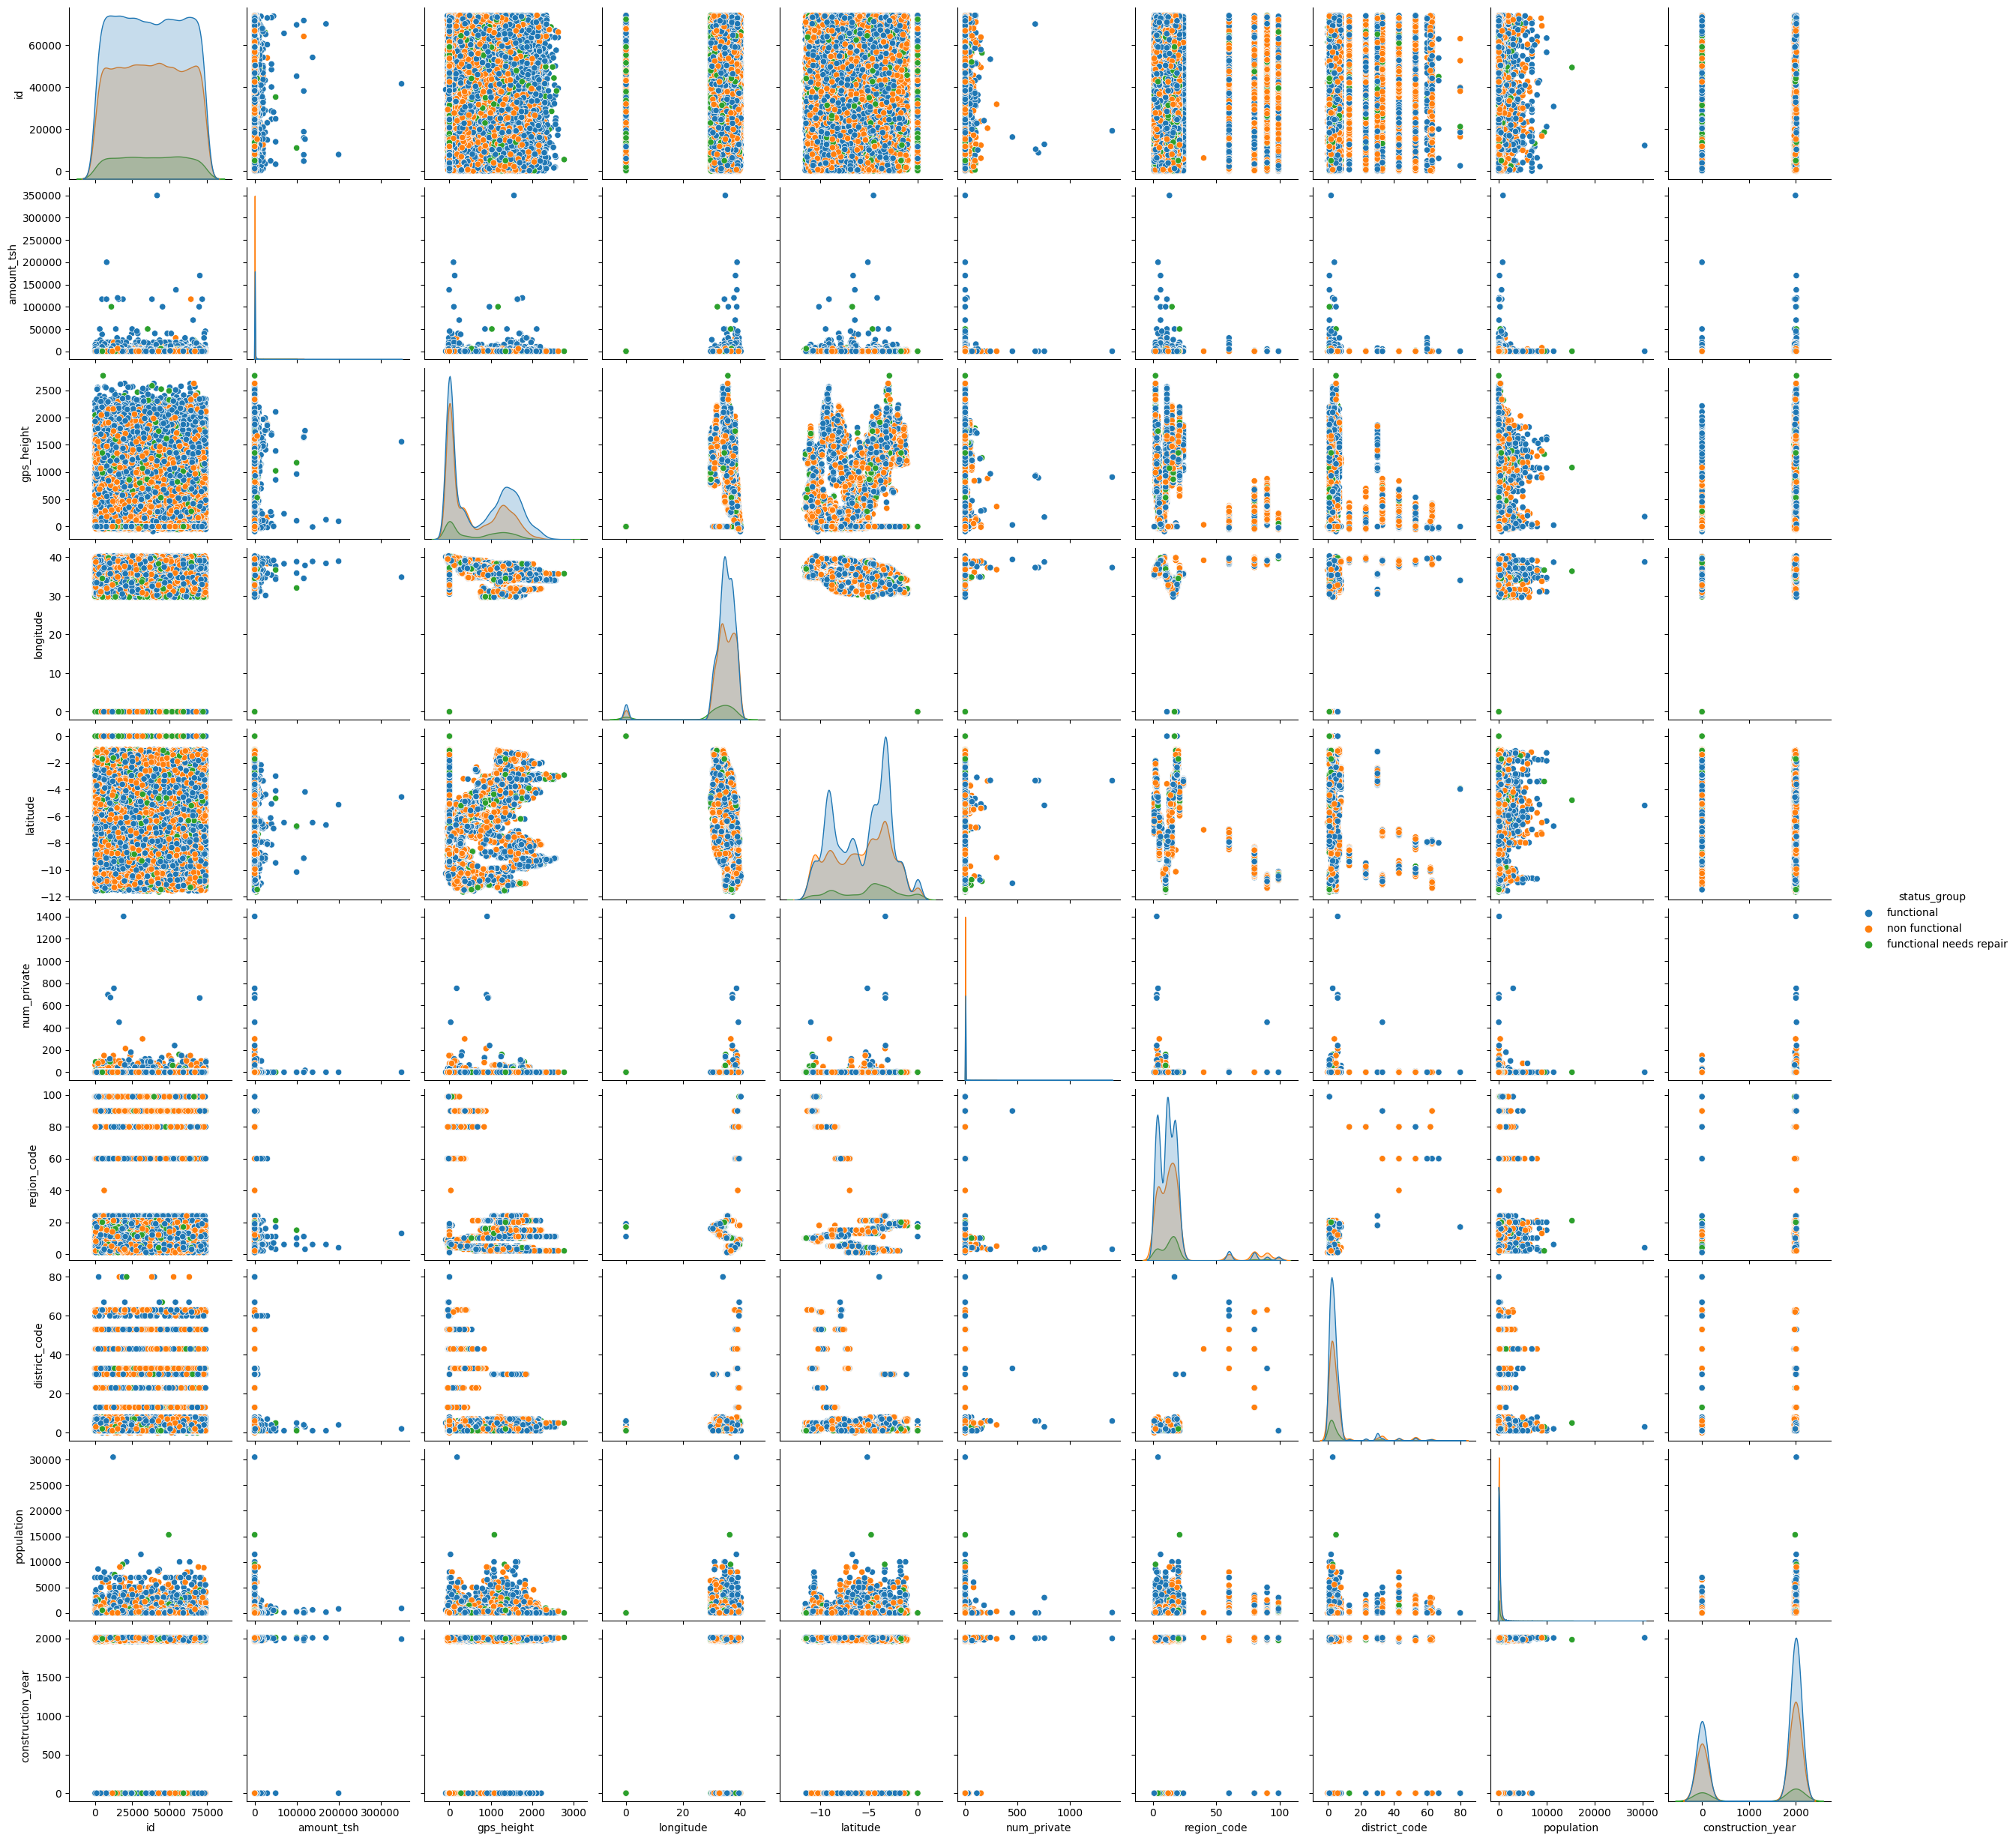

In [22]:
sns.pairplot(pd.concat((df_pump_train.select_dtypes(exclude="object"), df_pump_train["status_group"]), axis=1), hue="status_group")

## Data Preparation

## Pipeline

[Categoric Encoder Package ->](https://contrib.scikit-learn.org/category_encoders/index.html)

In [5]:
class YesNoEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, add_column = True):
        self.add_column = add_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.add_column:
            has_name = np.where(X['wpt_name']!= 'none', 1, 0)
            Xcopy = X
            Xcopy['wpt_name'] = has_name
        return Xcopy

In [6]:
class MyImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value="other"):
        self.fill_value = fill_value
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self.fill_value if str(x)==str(np.nan) else x for x in X]).reshape(-1,1)

In [7]:
scheme_pipeline = Pipeline([
('imputer', MyImputer(fill_value="other")),
('one_hot', OneHotEncoder())
])

In [38]:
scheme_pipeline_lbl = Pipeline([
    ('imputer', MyImputer(fill_value="other")),
    ('ord_enc', OrdinalEncoder()),
    ('min_max', MinMaxScaler())
])

In [8]:
class YearAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)
        

In [9]:
year_pipeline = Pipeline([
    ("add_year", YearAdder()),
    #("ord_enc", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ("scale", MinMaxScaler())
])

In [10]:
class AmountPerCapitaAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)

In [18]:
age_pipeline = Pipeline([
    ("imp_age", SimpleImputer(strategy="median")),
    ("scale", MinMaxScaler())
])

In [19]:
col_imp = Pipeline([
    ('simp_inputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [20]:
target_enc_pipe = Pipeline([
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

In [37]:
ord_enc_pipe = Pipeline([
    ('ord_enc', OrdinalEncoder()),
    ('min_max', MinMaxScaler())
])

In [44]:
df_train = df_pump_train.copy()

# add new target variables

df_train["t_functional"] = df_train["status_group"].apply(lambda x: 0 if x=="non functional" else 1)
df_train["t_needs_rep"] = df_train["status_group"].apply(lambda x: 1 if x=="functional needs repair" else 0)

# drop outliers
df_train = df_train.drop(df_train[df_train.longitude == 0].index)

# add some new features manually
df_train["amount_per_capita"] = df_train.apply(lambda x: x["amount_tsh"]/x["population"] if x["population"] != 0 else 0, axis=1)
import datetime
df_train["age"]=df_train['date_recorded'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))-df_train["construction_year"].apply(lambda x: datetime.datetime.strptime(str(x),'%Y') if x!=0 else datetime.datetime.now())
df_train["age"].loc[df_train["construction_year"]!=0]=df_train["age"].loc[df_train["construction_year"]!=0].apply(lambda x: x.days)
df_train["age"].loc[df_train["construction_year"]==0]=np.nan

# transform dtypes manually
df_train["district_code"] = df_train["district_code"].astype("category")
df_train["region_code"] = df_train["region_code"].astype("category")

y_train = df_train.loc[:,'status_group']
le = LabelEncoder()
y_train = le.fit_transform(y_train)

y_train_f = df_train["t_functional"]
y_train_r = df_train["t_needs_rep"]

col_trans = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['oh_enc', OneHotEncoder(), ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class']],
    ['bin_enc', BinaryEncoder(), ['region', 'region_code', 'district_code']], # warum alle 3 ?
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')

col_trans_lbl = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['ord_enc', ord_enc_pipe, ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class', 'region', 'region_code', 'district_code']],
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline_lbl, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')

col_trans_w_age = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['oh_enc', OneHotEncoder(), ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class']],
    ['bin_enc', BinaryEncoder(), ['region', 'region_code', 'district_code']], # warum alle 3 ?
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"],
    ["age", age_pipeline, ["age"]]
], remainder='drop')

col_trans_lbl_w_age = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['ord_enc', ord_enc_pipe, ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class', 'region', 'region_code', 'district_code']],
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline_lbl, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"],
    ["age", age_pipeline, ["age"]]
], remainder='drop')

/var/folders/m1/lfnpxhr54w36gr2xljxbctrh0000gn/T/ipykernel_38138/1718646054.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["age"].loc[df_train["construction_year"]!=0]=df_train["age"].loc[df_train["construction_year"]!=0].apply(lambda x: x.days)
/var/folders/m1/lfnpxhr54w36gr2xljxbctrh0000gn/T/ipykernel_38138/1718646054.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["age"].loc[df_train["construction_year"]==0]=np.nan


In [45]:
result = col_trans.fit_transform(X=df_train, y=y_train)
result_lbl = col_trans_lbl.fit_transform(X=df_train, y=y_train)
result_w_age = col_trans_w_age.fit_transform(X=df_train, y=y_train)
result_lbl_w_age = col_trans_lbl_w_age.fit_transform(X=df_train, y=y_train)

/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/Users/hammerer/opt/anaconda3/lib/python3.9/site-packages/category_encoders/target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/Users/hammerer/opt/anacond

In [46]:
print(result.shape)
print(result_lbl.shape)
print(result_w_age.shape)
print(result_lbl_w_age.shape)

(48958, 95)
(48958, 25)
(48958, 96)
(48958, 26)


In [47]:
print(f'({result.min()}, {result.max()})')
print(f'({result_lbl.min()}, {result_lbl.max()})')
print(f'({result_w_age.min()}, {result_w_age.max()})')
print(f'({result_lbl_w_age.min()}, {result_lbl_w_age.max()})')

(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
